## Continuous Optimization

#### *20 September 2019*
#### *DATA 1010*

We introduce numerical methods (iterative solvers) to optimize functions of one or more variables.

## Unconstrained Optimization

We use gradient descent to find the minimum of a real-valued function. For some function $f: \mathbb{R}^n \to \mathbb{R}$, and starting with initial guess $(\mathbf{x_0},f(\mathbf{x_0}))$, we can find the nearest minimum by iteratively moving in the direction of the negative gradient $-((\nabla f)(\mathbf{x_0}))'$:
$$ \mathbf{x_{i+1}} = \mathbf{x_{i}} - \epsilon ((\nabla f)(\mathbf{x_i}))' $$
for some positive step size $\epsilon$.

---

### Problem 1

Consider the function $f(x) = x^4 + x^3 - 11x^2 -9x + 18 = (x-3)(x-1)(x+2)(x+3)$ 

a) Plot $f(x)$ in the interval $x \in [-4,4]$. Use symbolic manipulation to calculate local minimima of $f$.

b) Implement gradient descent and use it to find a local minimum starting with initial guess $(x_0, f(x_0)) = (0, 18)$. Try different initial guesses. Can you find multiple minima values? 

c) For each local minimum, identify values of the guess $x_0$ that converge to the minimum value.

In [ ]:
# run this cell if you have not done so
using Pkg
Pkg.build("Statistics")

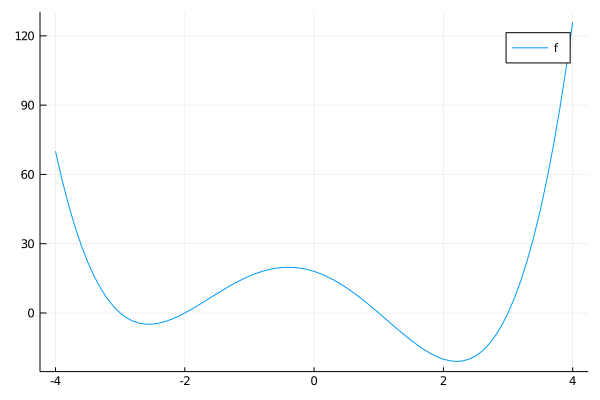

In [1]:
using Plots, SymPy
f(x) = (x-3)*(x-1)*(x+2)*(x+3)
plot(-4:0.1:4, f, label="f")

In [2]:
using ForwardDiff: gradient
derivative(f, x) = gradient(x->f(x[1]), [x])[1]

function graddescent(f, x₀, ϵ, threshold)
    x = x₀
    df(x) = derivative(f, x)
    while abs(df(x)) > threshold
        x = x - ϵ*df(x)
    end
    x
end

[graddescent(f, x, 0.01, 1e-12) for x = -4:4]

9-element Array{Float64,1}:
 -2.556891429344928
 -2.5568914293449327
 -2.5568914293448928
 -2.556891429344888
  2.2058239047198818
  2.205823904719876
  2.2058239047198844
  2.2058239047199075
  2.20582390471988

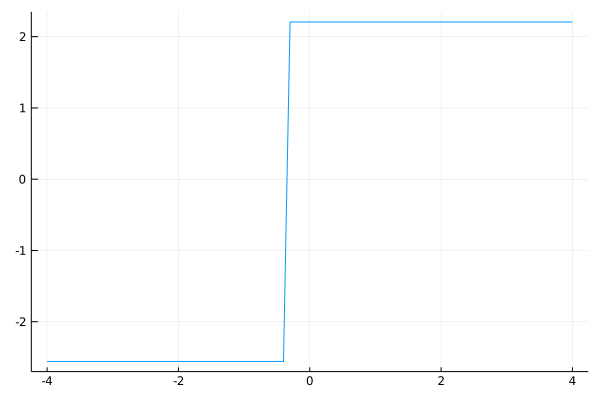

In [3]:
plot(-4:0.1:4, x -> graddescent(f, x, 0.01, 1e-12), legend = false)

---

### Problem 2

Consider Himmelblau's function: $f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$

a) Plot contours of this function. Identify local minima symbolically/analytically.

b) Use gradient descent to find minima of Himmelblau's function.

c) Can we use gradient descent to find local maxima? If so, how? 

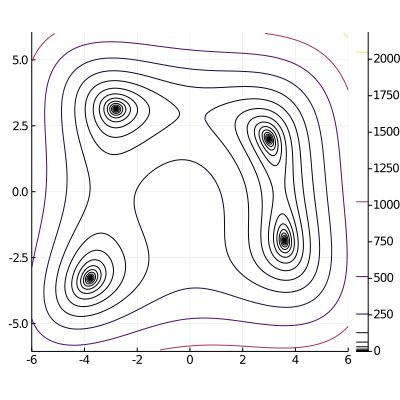

In [4]:
# (a)
f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
contour(-6:0.02:6, -6:0.02:6, f, 
        aspect_ratio = 1, 
        size = (400,400), 
        levels = [2.0^k for k in -6:11])

In [6]:
# (b)
@vars x y

#[(Float64(real(N(a))),Float64(real(N(b)))) 
#        for (a,b) in SymPy.solve([EQNS TO SOLVE HERE],(x,y))]
# hideall

[(Float64(real(N(a))),Float64(real(N(b))))
        for (a,b) in SymPy.solve([diff(f(x,y),x),diff(f(x,y),y)],(x,y))]

4-element Array{Tuple{Float64,Float64},1}:
 (3.0, 2.0)
 (-2.805118086952745, 3.131312518250573)
 (3.5844283403304917, -1.8481265269644036)
 (-3.779310253377747, -3.2831859912861696)

In [8]:
using LinearAlgebra

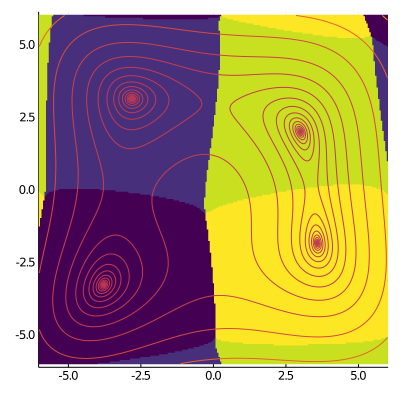

In [9]:
function graddescent(f, x₀, ϵ, threshold)
    df(x) = gradient(f,x)
    x = x₀
    while norm(df(x)) > threshold
        x = x - ϵ*df(x)
    end
    x
end
graddescent(v->f(v[1],v[2]), [2,-2.5], 0.01, 1e-12)

heatmap(-6:0.05:6, -6:0.05:6, (a,b) -> graddescent(v->f(v[1],v[2]), [a,b], 0.01, 1e-12)[1],
        ratio = 1, size = (400,400), fillcolor = :viridis)
contour!(-6:0.02:6, -6:0.02:6, (x,y)-> f(x,y)/1000,
        levels = [2.0^k/1000 for k in -6:11], colorbar = false)

## Constrained Optimization

There are usually practical or business reasons why some possible values of the variables involved in an optimization problem are excluded from consideration (for example, ones that suggest shipping a negative number of boxes of paper or executing a trade that would violate rules from the Securities and Exchange Commission). 

Applying constraints to optimization problems is also useful in machine learning for specifying how you want a model to behave. We will see an example of this when we study support vector machines.

Constrained optimization is handled symbolically using the method of Lagrange multipliers. In applied contexts, we typically encode the objective functions and constraints and hand it off to a *solver*. One of the most beloved systems for this task (encoding and handing the problem off to a solver) happens to be implemented in Julia: it's called **JuMP**. 

There are [many solvers](http://www.juliaopt.org/JuMP.jl/v0.19.0/installation/#Getting-Solvers-1) available, quite a few of which are commercial and require a license. A good open source one is [Ipopt] (pronounced eye-pea-opt). Let's see how to use JuMP to encode a simple problem and get Ipopt to solve it.

---

### Problem 3

Find the point on the ellipse $x^2 + 2y^2 = 1$ which is as close as possible to to the point $(1,1)$. Estimate by eyeballing it, and write your answer in the notebook *before* computing the exact answer.

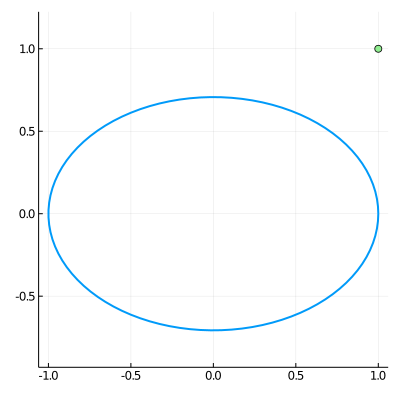

In [10]:
S¹ = range(0, 2π, length=100)
plot([cos(t) for t in S¹], [sin(t)/√(2) for t in S¹], aspect_ratio=1, size=(400,400), linewidth=2)
scatter!([(1,1)], legend=false, color = :lightgreen)

In [12]:
using JuMP, Ipopt
model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
@variable(model, x)
@variable(model, y)
@constraint(model, x^2 + 2y^2 == 1)
@objective(model, Min, (x-1)^2 + (y-1)^2)
optimize!(model)
JuMP.value.([x,y])

2-element Array{Float64,1}:
 0.6818306455515566
 0.5172557253364856

## Convex Optimization

Some optimization problems have a property called **convexity**, which is cool because it excludes the possibility of getting stuck in a local minimum:

**Theorem**  
If $f: A \to \mathbb{R}$ is convex and $A \subset \mathbb{R}^n$ is convex, then any local minimum of $f$ is also a global minimum of $f$. Furthermore, if $f$ is *strictly* convex, the $f$ has at most one local minimum.

Let's recall some definitions. A set $S$ is **convex** if for any two elements ${x,y} \in S$, the straight line connecting those points $\theta x + (1-\theta)y, \theta \in [0, 1]$ must lie entirely in $S$: 
$$ \theta x + (1-\theta)y \in S $$

A function $f: \mathbb{R}^n \to \mathbb{R}$ is convex if for ${\mathbf{x},\mathbf{y}}\in \mathbb{R}^n$ and any value $\theta \in [0,1]$, we have:
$$ f(\theta\mathbf{x} + (1-\theta)\mathbf{y}) \le \theta f(\mathbf{x}) + (1-\theta) f(\mathbf{y})$$
This is saying that every straight line connecting two points on the graph of $f$ must lie on or above the graph.

A constrained optimization problem:

$$ \text{min} f(\mathbf{x}) $$
subject to $$ g_i(\mathbf{x}) \le 0 \quad \forall i = 1,\cdots,m $$
and $$ h_j(\mathbf{x}) = 0 \quad \forall j = 1,\cdots,n$$

is called a *convex optimization problem* if $f(\mathbf{x})$ is convex, $g_i(\mathbf{x})$ is convex for each $i$, and the sets $\{\mathbf{x} : h_j(\mathbf{x}) = 0\}$ are convex.

---

### Problem 6

(a) The function $f(x,y) = \operatorname{e}^{(x^2 + y^2)/10}$ is convex. Plot it over the square $[-2,2]^2$ and also over the square $[2,4]^2$. Where is the global minimum of the two functions obtained by restricting $f$ to those two subsets of its domain?  
(b) Is the function $g(x,y) = -\operatorname{e}^{-x^2-y^2}$ convex? Hint: plot it.  
(c) Does $g$ have a unique global minimum? 

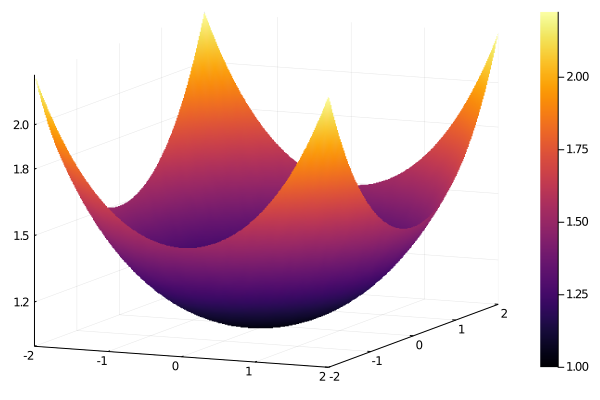

In [13]:
r = -2:0.1:2
surface(r, r, (x,y) -> exp((x^2 + y^2)/10))

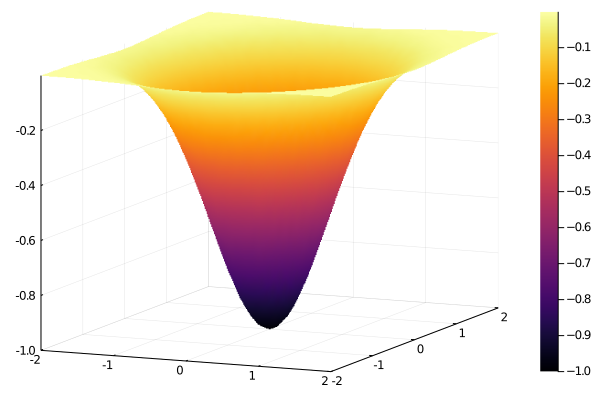

In [14]:
surface(-2:0.1:2, -2:0.1:2, (x,y) -> -exp(-x^2-y^2))

---

### Problem 5

a) Show that the problem:

$$ \text{minimize} \quad \mathbf{c}' \mathbf{x} $$ such that $$ |A_1 \mathbf{x}|^2 \le b_1 $$ and $$ A_2 \mathbf{x} = \mathbf{b}_2 $$ is convex for $\mathbf{x} \in \mathbb{R}^n$, $\mathbf{c} \in \mathbb{R}^n$, $A_1 \in \mathbb{R}^{m_1 \times n}$, $b_1 \in \mathbb{R}$, $A_2 \in \mathbb{R}^{m_2 \times n}$ and $\mathbf{b}_2 \in \mathbb{R}^{m_2}$. *Hint*: what is the shape of the set $|A_1 x|^2 \le b_1$?

b) Find the global minimum of the function for random matrices $A_1$, $A_2$; random vectors $c$ and $b_2$ and $b_1$ = 1.

c) Think of a business situation where you might want to maximize an expression like $\mathbf{c}'\mathbf{x}$. Why might there be a constraint of the form $A\mathbf{x} = \mathbf{b}$?

In [15]:
using JuMP, Ipopt, LinearAlgebra
using Random; Random.seed!(123) # set PRNG seed, for reproducibility

n = 2      # number of variables
m₁ = 2     # number of rows of A_1
m₂ = 2     # number of rows of A_2 and b_2

c = rand(n)
A₁ = randn(m₁, n)
b₁ = 1
A₂ = randn(m₂, n)
b₂ = randn(m₂)
         
model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

@variable(model, x[1:n])
@objective(model, Min, c' * x)
@constraint(model, A₂*x .== b₂)
@constraint(model, (A₁*x)'*(A₁*x) ≤ b₁)

optimize!(model)

println(string("Solution: ", repr(JuMP.value.(x)), "\n"))
println(string("A₂x: ", repr(A₂*JuMP.value.(x)), "\n"))
println(string("b₂: ", repr(b₂), "\n"))
println(string("||A₁x||: ", repr(norm(A₁*JuMP.value.(x))), "\n"))
println(string("c'x: ", repr(c' * JuMP.value.(x)), "\n"))

Solution: [-0.5026227620846359, 0.5612932835753717]

A₂x: [-0.3393660298004562, -0.07107996351809298]

b₂: [-0.33936602980781916, -0.84387792144707]

||A₁x||: 1.0000000049266105

c'x: 0.14166545997850333



---

### Challenge Problem

Rastrigin's function: $f(x,y) = 20 + (x-a)^2 + (y-b)^2 - 10(\cos(2 \pi (x-a)) + \cos(2 \pi (y-b)))$ is often used as a benchmark to test the efficiency of optimization methods. 

a) Why does this function pose a challenge for optimization algorithms? Where does it achieve it's global minimum?

b) How would you find the global minimum of this function using gradient descent?

c) Metaheuristic algorithms such as Genetic Algorithms, Particle Swarm Optimization, Simulated Annealing, Ant Colony Optimization and Tabu Search are often used to find global extrema of difficult to optimize functions. Implement one such algorithm to find the global minimum of Rastrigin's function for $(a,b) = (2,3)$.